In [2]:
# General imports
import numpy as np

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

# SciPy minimizer routine
from scipy.optimize import minimize

# rustworkx graph library
import rustworkx as rx
from rustworkx.visualization import mpl_draw

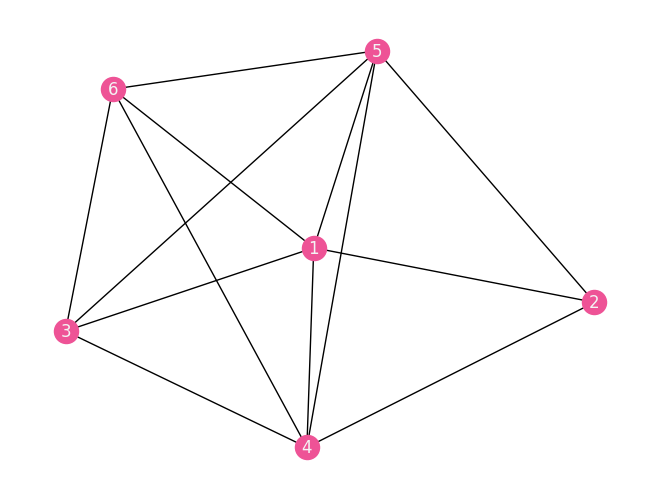

In [3]:
S1 = {1,2,4,5,6,8,9,10}
S2 = {1,4,6,7}
S3 = {5,8,9,11,12}
S4 = {4,7,8,9,10,11,12}
S5 = {2,3,4,5,6,7,11,12}
S6 = {3,10,12}

subsets = [S1, S2, S3, S4, S5, S6]
PROBLEM_DIM = len(subsets)

'''
S1 = {1,2,4,5,6,8,9,10}  si interseca con 2,3,4,5,6 -> 1,2,3,4,5
S2 = {1,4,6,7}           si interseca con 1,4,5 -> 0,3,4
S3 = {5,8,9,11,12}       si interseca con 1,4,5,6 -> 0,3,4,5
S4 = {4,7,8,9,10,11,12}  si interseca con 1,2,3,5,6 -> 0,1,2,4,5
S5 = {2,3,4,5,6,7,11,12} si interseca con 1,2,3,4,6 -> 0,1,2,3,5
S6 = {3,10,12}           si interseca con 1,3,4,5 -> 0,2,3,4
'''

# ***************************************************************
# The edge syntax is (start, end, weight)
edges = [(1, 2), (1, 3), (1, 4), (1, 5), (1, 6),
         (2, 4), (2, 5),
         (3, 4), (3, 5), (3, 6),
         (4, 5), (4, 6),
         (5, 6)]

G = rx.PyGraph()
G.add_nodes_from([i for i in range(1, PROBLEM_DIM+1)])
G.extend_from_edge_list(edges)
G.remove_node(0)
mpl_draw(
    G, with_labels=True, node_color="#EE5396", font_color="#F4F4F4"
)

Creo l'hamiltoniana

In [4]:
# H_P = l1 * \sum_i^n w_i *(1-Z_i)/2
#       - l2 * \sum_i^n (1-Z_i)/2
from itertools import permutations

# la dimensione deve essere fissata tenendo conto delle ancille
# che sono, al massimo, (numero_massimo_di_controlli - 1)
# quindi QC_DIM = 6 + (5 - 1) = 10
num_max_ctrl = 5
NUM_ANC = (num_max_ctrl - 1)
QC_DIM = PROBLEM_DIM + NUM_ANC

# ho provato anche a fare in modo che questa 
# hamiltoniana agisca solo sui primi 6,
# ma non funziona la misura finale in questo modo
labels = np.unique([''.join(p) + 'I'*(QC_DIM-6) for p in permutations('ZIIIII')])
print(labels)

l1 = 6/70
l2 = 1/70
coeffs = [- (l1*len(S)/2 - l2/2) for S in subsets]
hamiltonian = SparsePauliOp(labels, coeffs)

['IIIIIZIIII' 'IIIIZIIIII' 'IIIZIIIIII' 'IIZIIIIIII' 'IZIIIIIIII'
 'ZIIIIIIIII']


Creo un circuito per l'hamiltoniana ( in realtà funziona anche senza renderla un circuito)

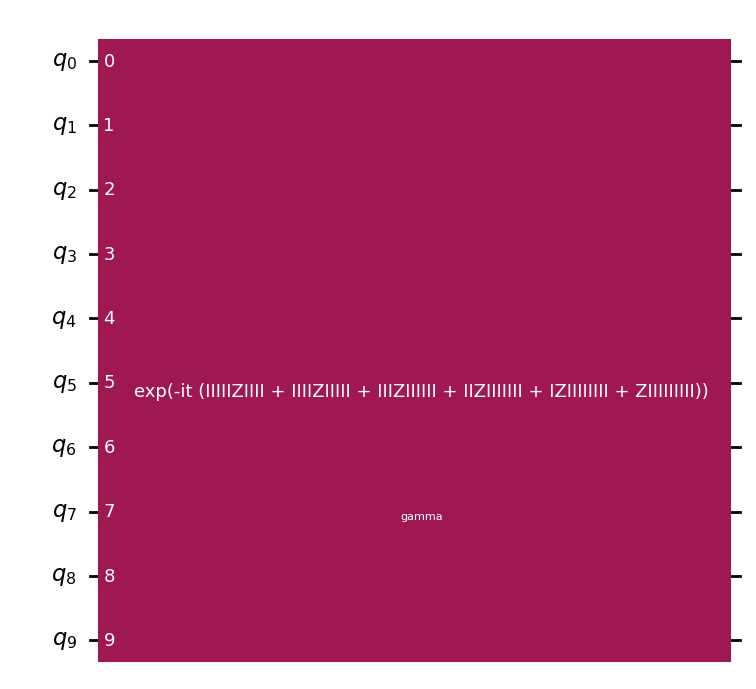

In [5]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit, QuantumRegister

gamma = Parameter("gamma")
evo = PauliEvolutionGate(hamiltonian, time=gamma)
 
qc_ham = QuantumCircuit(QC_DIM)
qc_ham.append(evo, range(QC_DIM))

qc_ham = qc_ham.decompose(reps=0)
qc_ham.draw(output="mpl", style="iqp")

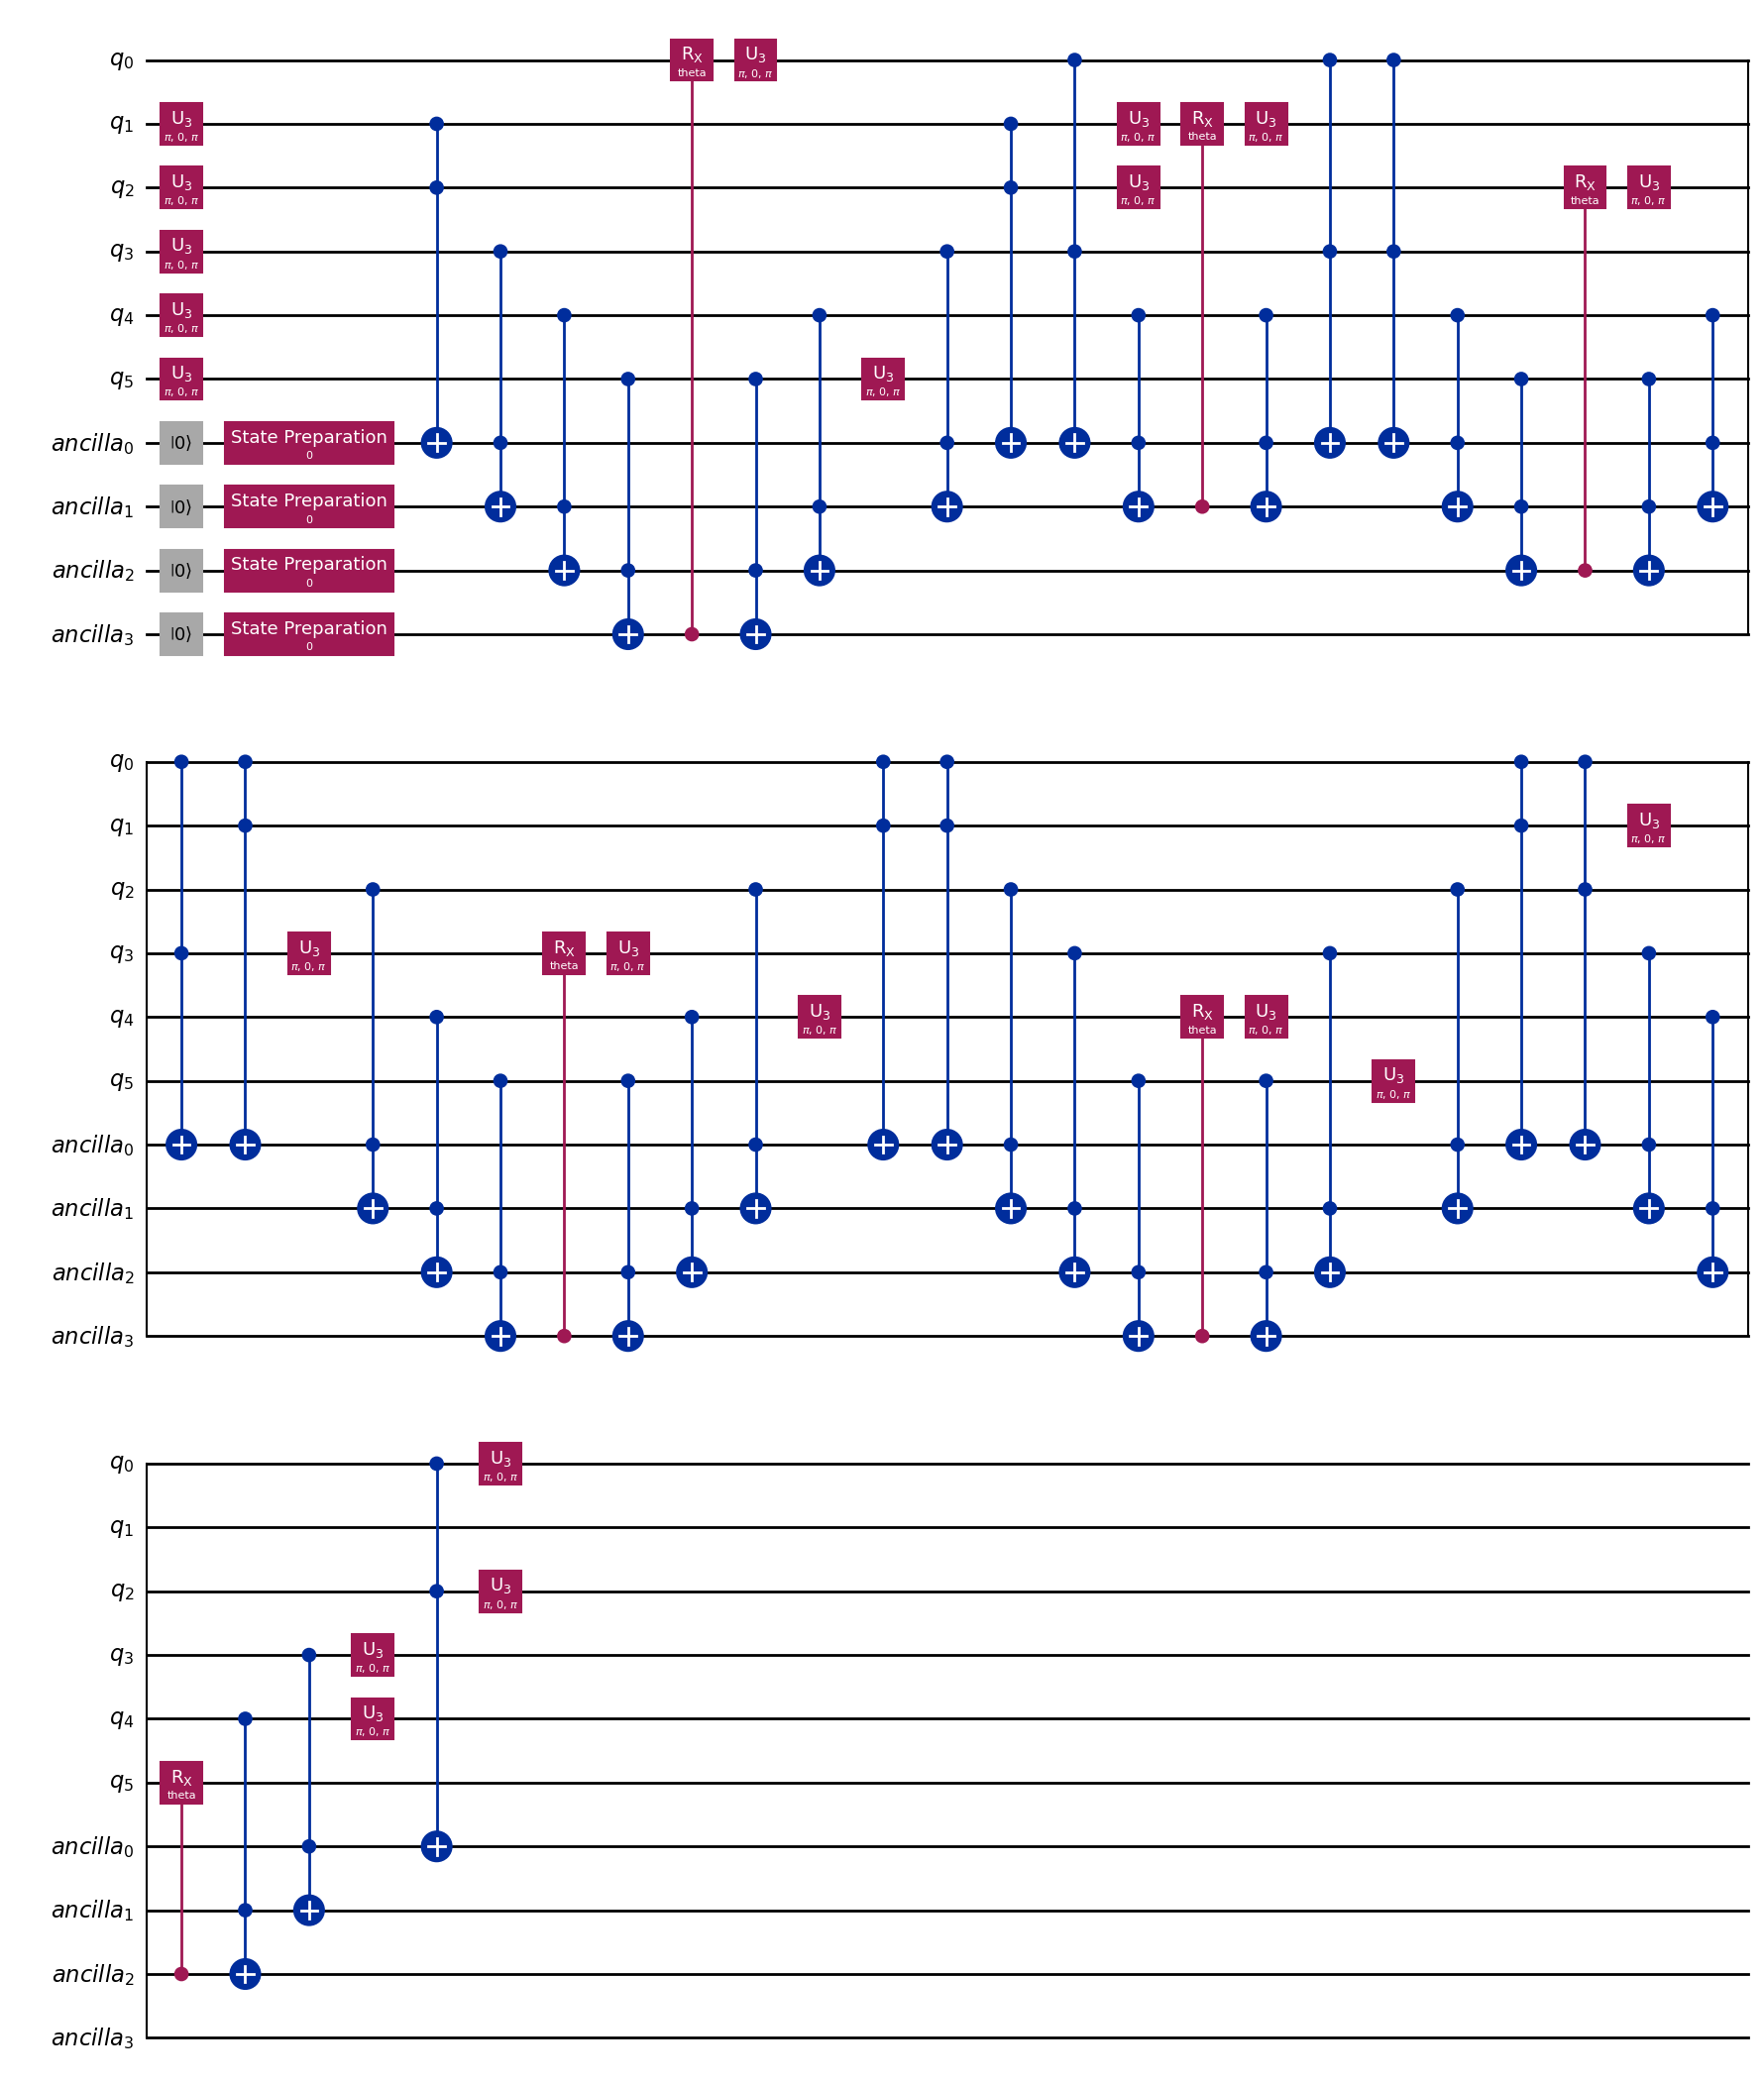

In [6]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library.standard_gates import RXGate
from qiskit.circuit import Parameter
from qiskit.circuit.library import MCMTVChain

# ***********************
# Inizializzo il circuito sapendo che servono (num_ctrl - 1) ancille per usare MCMTVChain
# nel nostro caso abbiamo 6 qubit + un massimo di 4 ancille -> 10 qubit necessari
qr = QuantumRegister(PROBLEM_DIM, 'q')
anc = QuantumRegister(NUM_ANC, 'ancilla')
qc_mixing = QuantumCircuit(qr, anc)

qc_mixing.initialize(0,6)
qc_mixing.initialize(0,7)
qc_mixing.initialize(0,8)
qc_mixing.initialize(0,9)


# ***********************
'''
S1 = {1,2,4,5,6,8,9,10}  si interseca con 2,3,4,5,6 -> 1,2,3,4,5
S2 = {1,4,6,7}           si interseca con 1,4,5     -> 0,3,4
S3 = {5,8,9,11,12}       si interseca con 1,4,5,6   -> 0,3,4,5
S4 = {4,7,8,9,10,11,12}  si interseca con 1,2,3,5,6 -> 0,1,2,4,5
S5 = {2,3,4,5,6,7,11,12} si interseca con 1,2,3,4,6 -> 0,1,2,3,5
S6 = {3,10,12}           si interseca con 1,3,4,5   -> 0,2,3,4
'''

theta = Parameter('theta') 

# Inizializzo dei gate che implementano (tramite VChain) 
# un diverso numero di controlli
gate_5ctrl = MCMTVChain(RXGate(theta), 5, 1).to_gate() 
gate_4ctrl = MCMTVChain(RXGate(theta), 4, 1).to_gate()
gate_3ctrl = MCMTVChain(RXGate(theta), 3, 1).to_gate() 


# Aggiungo al circuito i gate specificando quali devono essere i controlli
# prima i controlli, poi il target, poi le ancille (che sono [6,7,8,9])
qc_mixing.x([1,2,3,4,5])
qc_mixing.append(gate_5ctrl, [1,2,3,4,5, 0, 6,7,8,9])  #S1
qc_mixing.x([1,2,5])
qc_mixing.x([0])
qc_mixing.append(gate_3ctrl, [0,3,4, 1, 6,7])          #S2
# qc_mixing.x([5]) # lo tolgo perché xx = id
qc_mixing.append(gate_4ctrl, [0,3,4,5, 2, 6,7,8])      #S3
qc_mixing.x([3])
qc_mixing.x([1,2])
qc_mixing.append(gate_5ctrl, [0,1,2,4,5, 3, 6,7,8,9])  #S4
qc_mixing.x([4])
qc_mixing.x([3])
qc_mixing.append(gate_5ctrl, [0,1,2,3,5, 4, 6,7,8,9])  #S5
qc_mixing.x([1,5])
qc_mixing.x([4])
qc_mixing.append(gate_4ctrl, [0,2,3,4, 5, 6,7,8])      #S6
qc_mixing.x([0,2,3,4])

qc_mixing.decompose().draw('mpl')

Creo il QAOA ansatz

numero ancille =  0


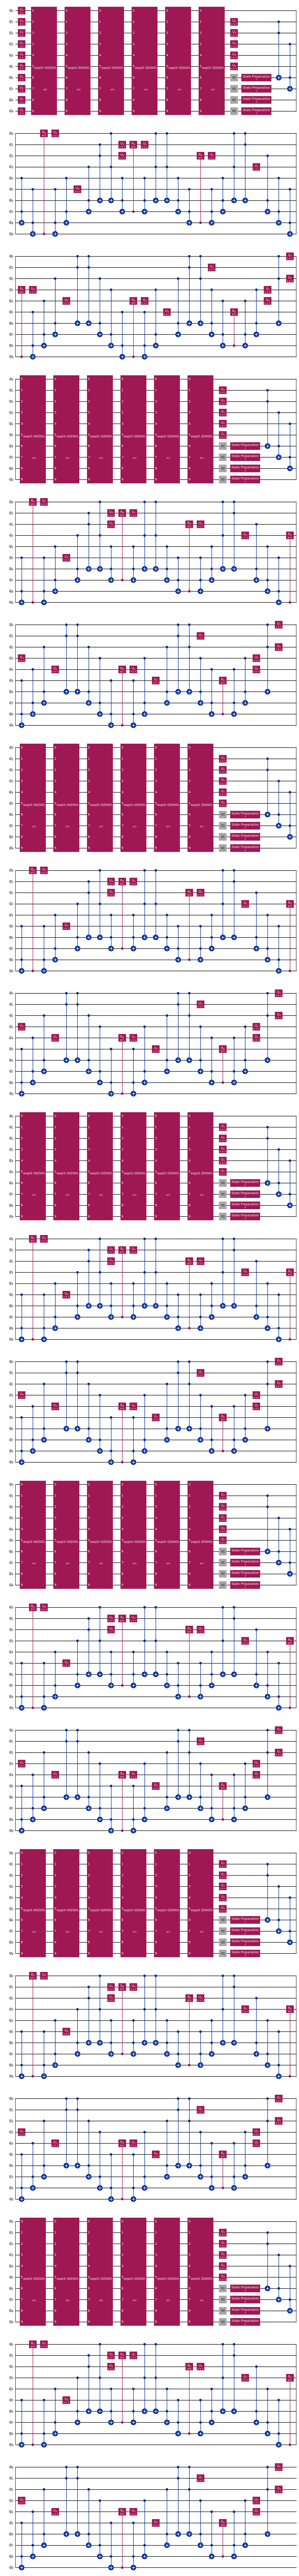

In [7]:
ansatz = QAOAAnsatz(qc_ham, mixer_operator=qc_mixing, reps=7, name='my_QAOA_circuit')
# ansatz = QAOAAnsatz(hamiltonian, reps=1)
print("numero ancille = ", ansatz.num_ancillas)

ansatz.decompose(reps=2).draw(output="mpl", style="iqp")

### Simulazione con Statevector


In [8]:
# Generate a pass manager without providing a backend
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=3)
ansatz_isa = pm.run(ansatz)
hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)
hamiltonian_isa

SparsePauliOp(['IIIIIZIIII', 'IIIIZIIIII', 'IIIZIIIIII', 'IIZIIIIIII', 'IZIIIIIIII', 'ZIIIIIIIII'],
              coeffs=[-0.33571429+0.j, -0.16428571+0.j, -0.20714286+0.j, -0.29285714+0.j,
 -0.33571429+0.j, -0.12142857+0.j])

In [9]:
from qiskit.primitives import StatevectorEstimator, StatevectorSampler

estimator = StatevectorEstimator()
sampler = StatevectorSampler()

In [10]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    cost = result[0].data.evs[0]

    return cost

In [11]:
x0 = 2 * np.pi * np.random.rand(ansatz_isa.num_parameters)
res = minimize(cost_func, x0, args=(ansatz_isa, hamiltonian_isa, estimator), method="COBYLA")

In [12]:
print(res)
print(len(res.x))

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -1.0122581303365115
       x: [ 1.867e+00  6.087e+00 ...  1.912e+00  3.080e+00]
    nfev: 1000
   maxcv: 0.0
14


### Risultati

Assegno i parametri trovati all'ansatz

In [13]:
qc = ansatz.assign_parameters(res.x)

# Add measurements to our circuit
qc.measure_all()
qc_isa = pm.run(qc)
# qc_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [14]:
result = sampler.run([qc_isa]).result()
print(sampler.default_shots)
samp_dist = result[0].data.meas.get_counts()
print(samp_dist)

1024
{'0000111101': 24, '0000011101': 26, '0000000010': 6, '0000001001': 20, '0000000001': 57, '0000010100': 20, '0000011111': 16, '0000010110': 17, '0000101111': 12, '0000111011': 18, '0000100011': 16, '0000111110': 27, '0000110101': 17, '0000010011': 13, '0000001110': 11, '0000000100': 90, '0000111010': 11, '0000110100': 12, '0000101011': 16, '0000001000': 8, '0000010111': 11, '0000001011': 18, '0000110111': 10, '0000000000': 35, '0000011100': 13, '0000111001': 11, '0000101110': 11, '0000110011': 23, '0000000101': 11, '0000010101': 18, '0000001101': 20, '0000010010': 22, '0000111100': 11, '0000011001': 16, '0000100101': 17, '0000000011': 15, '0000110010': 19, '0000011110': 14, '0000011000': 16, '0000001010': 16, '0000100111': 17, '0000001100': 19, '0000101100': 17, '0000110110': 15, '0000111000': 13, '0000000110': 11, '0000111111': 15, '0000101101': 17, '0000011010': 12, '0000011011': 18, '0000101001': 13, '0000101010': 16, '0000110001': 22, '0000100100': 3, '0000001111': 16, '000000

## Ora droppo i primi 4 bit (le ancille) e raggruppo stati uguali (sommando i rispettivi counts)

In [15]:
import pandas as pd
df = pd.DataFrame(samp_dist.items())
df = df.rename(columns={0: 'states', 1: 'counts'})
df.head()

,states,counts
0,0000111101,24
1,0000011101,26
2,0000000010,6
3,0000001001,20
4,0000000001,57


In [16]:
df['states'] = df['states'].apply(lambda x: x[NUM_ANC:])
df.head()

,states,counts
0,111101,24
1,011101,26
2,000010,6
3,001001,20
4,000001,57


In [17]:
df_grouped = df.groupby(['states']).sum()
df_grouped.head()

,counts
states,
000000,35
000001,57
000010,6
000011,15
000100,90


In [18]:
grouped_dict = df_grouped['counts'].to_dict()
grouped_dict

{'000000': 35,
 '000001': 57,
 '000010': 6,
 '000011': 15,
 '000100': 90,
 '000101': 11,
 '000110': 11,
 '000111': 12,
 '001000': 8,
 '001001': 20,
 '001010': 16,
 '001011': 18,
 '001100': 19,
 '001101': 20,
 '001110': 11,
 '001111': 16,
 '010000': 1,
 '010001': 18,
 '010010': 22,
 '010011': 13,
 '010100': 20,
 '010101': 18,
 '010110': 17,
 '010111': 11,
 '011000': 16,
 '011001': 16,
 '011010': 12,
 '011011': 18,
 '011100': 13,
 '011101': 26,
 '011110': 14,
 '011111': 16,
 '100001': 1,
 '100010': 2,
 '100011': 16,
 '100100': 3,
 '100101': 17,
 '100111': 17,
 '101000': 2,
 '101001': 13,
 '101010': 16,
 '101011': 16,
 '101100': 17,
 '101101': 17,
 '101110': 11,
 '101111': 12,
 '110001': 22,
 '110010': 19,
 '110011': 23,
 '110100': 12,
 '110101': 17,
 '110110': 15,
 '110111': 10,
 '111000': 13,
 '111001': 11,
 '111010': 11,
 '111011': 18,
 '111100': 11,
 '111101': 24,
 '111110': 27,
 '111111': 15}

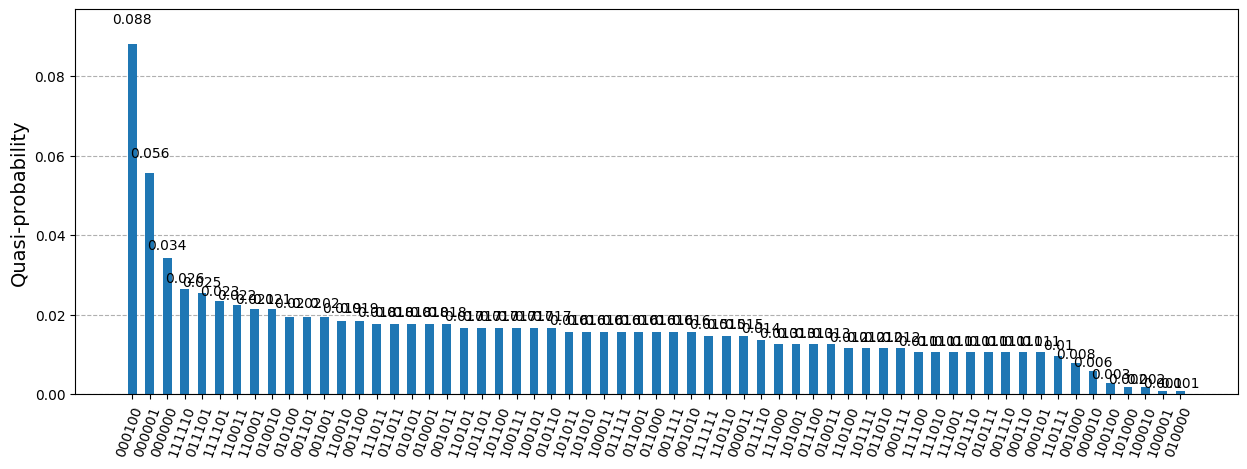

In [19]:
plot_distribution(grouped_dict, figsize=(15, 5), sort='value_desc')

# ALTRO


### alcune prove

In [20]:
# from qiskit import QuantumCircuit, QuantumRegister
# from qiskit.circuit.library.standard_gates import HGate, RXGate, XGate
# from qiskit.circuit import Parameter
# from qiskit.circuit import ControlledGate

### PROVA 1 #### 
# '''
# se uso "ControlledGate" il QAOAAnsatz funziona ma il transpiler dà errore
# '''
# qc_mixing = QuantumCircuit(6, name='Mixing Circuit')

# theta = Parameter("theta")
# rrx = RXGate(theta)


# def build_ccrx(num_ctrl_qubits):
#     '''
#     costruisce una rotazione x controllata con num_ctrl_qubits controlli
#     '''
#     ccrx = ControlledGate(name="crx", num_qubits=num_ctrl_qubits+1, 
#                           params=rrx.params, num_ctrl_qubits=num_ctrl_qubits, 
#                           definition=rrx.definition,
#                           ctrl_state='0'*num_ctrl_qubits,
#                           base_gate=rrx) #ctrl_state to custom control state
#     return ccrx

# qc_mixing.append(build_ccrx(5),[1,2,3,4,5,0]) # l'ultimo è dove mette Rx
# qc_mixing.append(build_ccrx(3),[0,3,4,1])
# qc_mixing.append(build_ccrx(4),[0,3,4,5,2])
# qc_mixing.append(build_ccrx(5),[0,1,2,4,5,3])
# qc_mixing.append(build_ccrx(5),[0,1,2,3,5,4])
# qc_mixing.append(build_ccrx(4),[0,2,3,4,5])

# qc_mixing.decompose(reps=1).draw(output="mpl", style="iqp")


### PROVA 2 #### "control" NON FUNZIONA CON PIU' DI 3 CONTROLLI !

# from qiskit.circuit.library import MCXGate
# c2rx = RXGate(theta).control(2, ctrl_state=00)
# circuit.append(c2rx, [0, 5, 3])
# circuit.append(MCXGate(4), [1, 3, 4, 5, 2])
# circuit.append()


#####
# qc = QuantumCircuit(9)
# qc.mct([0,1,2,3], 4)
# # qc.ccx(0, 1, 2)
# qc.mcx(control_qubits=[0,1,2,4,5], target_qubit=3, ancilla_qubits=[6,7,8], mode='basic', ctrl_state='00000')
# qc.decompose(reps=1).draw(output="mpl", style="iqp")

### senza simulatore

In [21]:
# # Qiskit Runtime
# from qiskit_ibm_runtime import QiskitRuntimeService, Session
# from qiskit_ibm_runtime import EstimatorV2 as Estimator
# from qiskit_ibm_runtime import SamplerV2 as Sampler

# # To run on hardware, select the backend with the fewest number of jobs in the queue
# service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(operational=True, simulator=False)
# backend.name

In [22]:
# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# target = backend.target
# pm = generate_preset_pass_manager(target=target, optimization_level=3)

# ansatz_isa = pm.run(ansatz)

Con simulatore:


In [23]:
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2, FakeManilaV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend = FakeAlmadenV2()
estimator = Estimator(backend)
target = backend.target

pm = generate_preset_pass_manager(optimization_level=1, target=target)

ansatz_isa = pm.run(ansatz)

TranspilerError: "HighLevelSynthesis was unable to synthesize Instruction(name='reset', num_qubits=1, num_clbits=0, params=[])."

Altra prova

In [ ]:
# ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [ ]:
hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)
hamiltonian_isa

In [ ]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    cost = result[0].data.evs[0]

    return cost

In [ ]:
x0 = 2 * np.pi * np.random.rand(ansatz_isa.num_parameters)

Method COBYLA uses the Constrained Optimization BY Linear Approximation (COBYLA) method [9], [10], [11]. The algorithm is based on linear approximations to the objective function and each constraint. The method wraps a FORTRAN implementation of the algorithm. The constraints functions ‘fun’ may return either a single number or an array or list of numbers

In [ ]:
res = minimize(cost_func, x0, args=(ansatz_isa, hamiltonian_isa, estimator), method="COBYLA")

In [ ]:
res

## Post-process, return result in classical format

In [ ]:
# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(res.x)

# Add measurements
qc.measure_all()
qc_isa = pm.run(qc)
# qc_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [ ]:
from qiskit.primitives import StatevectorSampler
 
sampler = StatevectorSampler()
result = sampler.run([qc_isa]).result()
samp_dist = result[0].data.meas.get_counts()

In [ ]:
plot_distribution(samp_dist, figsize=(15, 5), sort='value_desc', number_to_keep=10)